LSTM Model <br>
인공지능 모델 자체가 메모리를 가지고 있어서 이전 데이터를 가지고 후 데이터를 예측하는 모델


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

Using TensorFlow backend.


Load Dataset from Yahoo Finance<br>
https://finance.yahoo.com/quote/005930.KS/history?p=005930.KS<br>
- If file has null data, it causes model training fail
- Erase null data from file

In [59]:
CODEPATH = "D:/GitHub/stock_crypto_price_prediction_clone" # Modify 
DATAPATH = "D:/00_MLDL/00_BreadBrother/00_Stock" # Modify
data = pd.read_csv(f"{DATAPATH}/005930.KS.csv")
data = data.dropna(how="any") # if row has null data drop it
data.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-08-07,22400,22740,22300,22720,229.302444,13787100
1,2015-08-10,22800,22840,22600,22820,230.311722,5722500
2,2015-08-11,23020,23580,22960,23140,233.541336,11664300
3,2015-08-12,23000,23280,22800,23080,232.935745,11154000
4,2015-08-13,23060,23060,22760,22800,230.109848,7520550


Compute Mid Price

In [60]:
high_prices = data["High"].values
low_prices = data["Low"].values
mid_prices = (high_prices + low_prices) / 2

Create Windows

In [61]:
seq_len = 50
sequence_length = seq_len + 1

result = []

# 51개 데이터를 묶어서 리스트로 저장
# 1228-51 = 51 X 1177개의 array 생성
for index in range(len(mid_prices) - sequence_length) :
    result.append(mid_prices[index: index+sequence_length])

Normalize Data

In [62]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

# 1177 X 51 array
normalized_result = np.array(normalized_data)

# Split train and test data
# row = int(round(normalized_result.shape[0] * 0.9))
row = int(round(normalized_result.shape[0] * 0.8))

# 1059 X 51 array
train = normalized_result[:row, :]
np.random.shuffle(train)

# 1059 X 50
x_train = train[:, :-1]
# 1059 X 50 X 1
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# 1059 X 1
y_train = train[:, -1]

# 118 X 50
test = normalized_result[row:, :]
x_test = test[:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = test[:, -1]

x_train.shape, x_test.shape

((1055, 50, 1), (117, 50, 1))

<h5>Build a Model</h5>

In [63]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


Training

In [64]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20)

Train on 1055 samples, validate on 117 samples
Epoch 1/20
1055/1055 [==============================] - 19s 18ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 2/20
1055/1055 [==============================] - 18s 17ms/step - loss: 7.3232e-04 - val_loss: 0.0011
Epoch 3/20
1055/1055 [==============================] - 17s 17ms/step - loss: 5.4606e-04 - val_loss: 0.0020
Epoch 4/20
1055/1055 [==============================] - 18s 17ms/step - loss: 4.0034e-04 - val_loss: 8.1279e-04
Epoch 5/20
1055/1055 [==============================] - 17s 17ms/step - loss: 3.2631e-04 - val_loss: 5.4825e-04
Epoch 6/20
1055/1055 [==============================] - 18s 17ms/step - loss: 2.7853e-04 - val_loss: 5.3916e-04
Epoch 7/20
1055/1055 [==============================] - 18s 17ms/step - loss: 2.5591e-04 - val_loss: 4.2528e-04
Epoch 8/20
1055/1055 [==============================] - 18s 17ms/step - loss: 2.4759e-04 - val_loss: 4.9686e-04
Epoch 9/20
1055/1055 [==============================] - 18s 17ms/step - l

Prediction

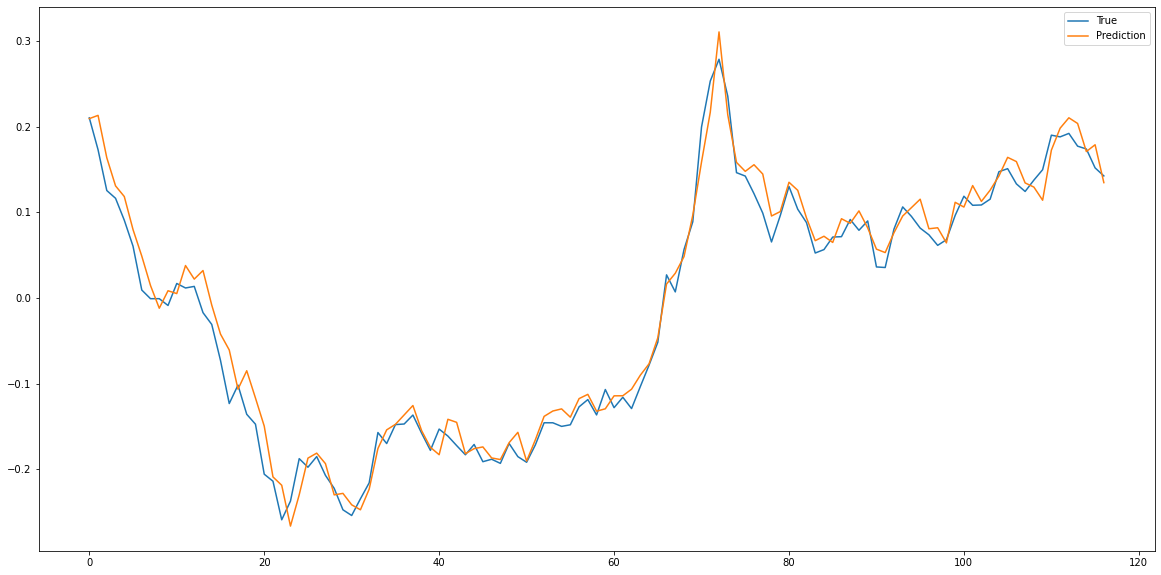

In [65]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()